In [1]:
import copy
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import SAC
from torch import cuda
from torch.backends import mps

from _utils import generate_ap_locations, generate_ue_locations
from compute_spectral_efficiency import compute_se
from env import MobilityCFmMIMOEnv
from simulation_para import L, K, max_power, square_length

In [2]:
if sys.platform == 'darwin':  # Check if macOS
    device = "mps" if mps.is_available() else "cpu"
else:
    device = "cuda" if cuda.is_available() else "cpu"

In [3]:
area_bounds = (0, square_length, 0, square_length)
APs_positions = generate_ap_locations(L, 100, area_bounds)
UEs_positions = generate_ue_locations(K, area_bounds)

In [4]:
algo_name = "SAC"
optim_name = "SGD"
reward_method = "channel_capacity"
models_dir = 'models'
models_folder = f'{algo_name}-{optim_name}-{reward_method}'
model1_name = 'MobilityCFmMIMOEnv_SAC_SGD_channel_capacity_20231230-2008'
model_path = os.path.join(models_dir, models_folder, model1_name)
model_ch_cap = SAC.load(model_path)

reward_method = "geo_mean_se"
models_folder = f'{algo_name}-{optim_name}-{reward_method}'
model2_name = 'MobilityCFmMIMOEnv_SAC_SGD_geo_mean_se_20231230-2035'
model_path = os.path.join(models_dir, models_folder, model2_name)
model_geo_mean = SAC.load(model_path)

reward_method = "mean_se"
models_folder = f'{algo_name}-{optim_name}-{reward_method}'
model2_name = 'MobilityCFmMIMOEnv_SAC_SGD_mean_se_20231230-1528'
model_path = os.path.join(models_dir, models_folder, model2_name)
model_mean = SAC.load(model_path)

reward_method = "min_se"
models_folder = f'{algo_name}-{optim_name}-{reward_method}'
model4_name = 'MobilityCFmMIMOEnv_SAC_SGD_min_se_20231230-2044'
model_path = os.path.join(models_dir, models_folder, model4_name)
model_min = SAC.load(model_path)

reward_method = "sum_se"
models_folder = f'{algo_name}-{optim_name}-{reward_method}'
model5_name = 'MobilityCFmMIMOEnv_SAC_SGD_sum_se_20231230-2054'
model_path = os.path.join(models_dir, models_folder, model5_name)
model_sum = SAC.load(model_path)

In [5]:
# specify if the SE is calculated with previous SINR terms (lagging) or with the current SINR terms
lagging_SE = False

In [6]:
num_of_setups = 100
prelog_factor = 1

reward_method options:
- channel_capacity
- geo_mean_se
- mean_se
- min_se
- sum_se

In [7]:
env = MobilityCFmMIMOEnv(APs_positions=APs_positions, UEs_positions=UEs_positions, UEs_mobility=True,
                         reward_method='channel_capacity')

In [8]:
cf_signal = np.zeros((K, num_of_setups))
cf_interference = np.zeros((K, K, num_of_setups))
cf_pred_power = np.zeros((K, num_of_setups))

cf_SE_model_ch_cap = np.zeros((K, num_of_setups))

SE_maxmin_cell = np.zeros((K, num_of_setups))
SE_maxprod_cell = np.zeros((K, num_of_setups))
SE_sumrate_cell = np.zeros((K, num_of_setups))

over_all_time = time.time()

for n in range(num_of_setups):
    obs, info = env.reset()

    init_signal = info['init_signal']
    init_interference = info['init_interference']
    init_pilot_index = info['init_pilot_index']
    init_beta_val = info['init_beta_val']

    # DRL Agent
    action, _ = model_ch_cap.predict(obs, deterministic=True)
    info = env.calculate(init_signal, init_interference, action, lagging_SE, init_pilot_index, init_beta_val)
    cf_SE_model_ch_cap[:, n] = compute_se(info['signal'], info['interference'], info['predicted_power'], prelog_factor)

    # native power optimization algorithms
    info = env.maxmin_algo(init_signal, init_interference, max_power, None, prelog_factor, lagging_SE, init_pilot_index,
                           init_beta_val)
    SE_maxmin_cell[:, n] = compute_se(info['signal'], info['interference'], info['optimized_power'], prelog_factor)

    info = env.maxprod_algo(init_signal, init_interference, max_power, None, prelog_factor, lagging_SE,
                            init_pilot_index, init_beta_val)
    SE_maxprod_cell[:, n] = compute_se(info['signal'], info['interference'], info['optimized_power'], prelog_factor)

    info = env.maxsumrate_algo(init_signal, init_interference, max_power, None, prelog_factor, lagging_SE,
                               init_pilot_index, init_beta_val)
    SE_sumrate_cell[:, n] = compute_se(info['signal'], info['interference'], info['optimized_power'], prelog_factor)

print('Total inference: ', time.time() - over_all_time)

Total inference:  55.96998310089111


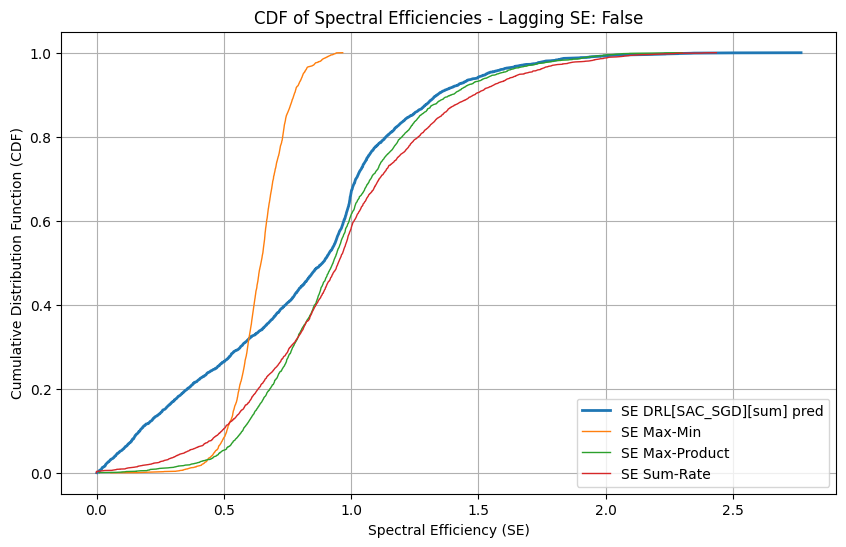

In [9]:
model_ch_cap_flatten = cf_SE_model_ch_cap.flatten()
sorted_model_ch_cap = np.sort(model_ch_cap_flatten)
model_ch_cap_pred = np.linspace(0, 1, len(sorted_model_ch_cap))

SE_maxmin_flatten = SE_maxmin_cell.flatten()
SE_maxprod_flatten = SE_maxprod_cell.flatten()
SE_sumrate_flatten = SE_sumrate_cell.flatten()

sorted_SE_maxmin = np.sort(SE_maxmin_flatten)
sorted_SE_maxprod = np.sort(SE_maxprod_flatten)
sorted_SE_sumrate = np.sort(SE_sumrate_flatten)

cdf_SE_maxmin = np.linspace(0, 1, len(sorted_SE_maxmin))
cdf_SE_maxprod = np.linspace(0, 1, len(sorted_SE_maxprod))
cdf_SE_sumrate = np.linspace(0, 1, len(sorted_SE_sumrate))

plt.figure(figsize=(10, 6))

plt.plot(sorted_model_ch_cap, model_ch_cap_pred, label='SE DRL[SAC_SGD][sum] pred', linewidth=2)

plt.plot(sorted_SE_maxmin, cdf_SE_maxmin, label='SE Max-Min', linewidth=1)
plt.plot(sorted_SE_maxprod, cdf_SE_maxprod, label='SE Max-Product', linewidth=1)
plt.plot(sorted_SE_sumrate, cdf_SE_sumrate, label='SE Sum-Rate', linewidth=1)

plt.xlabel('Spectral Efficiency (SE)')
plt.ylabel('Cumulative Distribution Function (CDF)')
plt.title(f'CDF of Spectral Efficiencies - Lagging SE: {lagging_SE}')
plt.legend()
plt.grid(True)
plt.show()

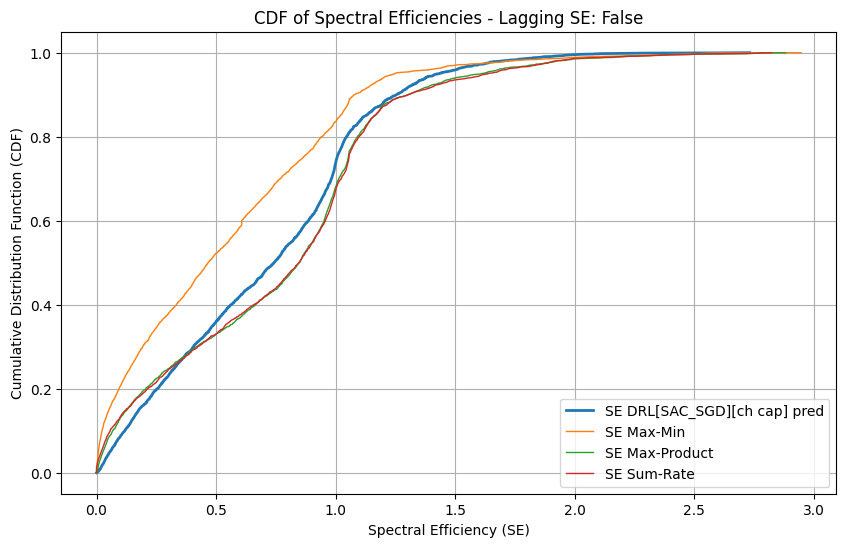

In [10]:
env = MobilityCFmMIMOEnv(APs_positions=APs_positions, UEs_positions=UEs_positions, UEs_mobility=True,
                         reward_method='channel_capacity')

cf_signal = np.zeros((K, num_of_setups))
cf_interference = np.zeros((K, K, num_of_setups))
cf_pred_power = np.zeros((K, num_of_setups))

cf_SE_model_ch_cap = np.zeros((K, num_of_setups))

SE_maxmin_cell = np.zeros((K, num_of_setups))
SE_maxprod_cell = np.zeros((K, num_of_setups))
SE_sumrate_cell = np.zeros((K, num_of_setups))


obs, info = env.reset()
signal = info['init_signal']
interference = info['init_interference']

prelog_factor = 1

env2 = copy.deepcopy(env)
env3 = copy.deepcopy(env)
env4 = copy.deepcopy(env)

maxmin_signal = copy.deepcopy(signal)
maxprod_signal = copy.deepcopy(signal)
maxsumrate_signal = copy.deepcopy(signal)

maxmin_interference = copy.deepcopy(interference)
maxprod_interference = copy.deepcopy(interference)
maxsumrate_interference = copy.deepcopy(interference)

for n in range(num_of_setups):
    # DRL Agent
    action, _ = model_ch_cap.predict(obs, deterministic=True)
    obs, _, _, _, info = env.step(action)
    cf_SE_model_ch_cap[:, n] = compute_se(info['signal'], info['interference'], info['predicted_power'], prelog_factor)

    updated_ues_positions = info['ues_positions']

    info = env2.maxmin_algo(maxmin_signal, maxmin_interference, max_power, updated_ues_positions, prelog_factor,
                            lagging_SE, None, None)
    maxmin_signal = info['signal']
    maxmin_interference = info['interference']
    maxmin_opt_power = info['optimized_power']
    SE_maxmin_cell[:, n] = compute_se(signal, interference, maxmin_opt_power, prelog_factor)

    info = env3.maxprod_algo(maxprod_signal, maxprod_interference, max_power, updated_ues_positions, prelog_factor,
                             lagging_SE, None, None)
    maxprod_signal = info['signal']
    maxprod_interference = info['interference']
    maxprod_opt_power = info['optimized_power']
    SE_maxprod_cell[:, n] = compute_se(signal, interference, maxprod_opt_power, prelog_factor)

    info = env4.maxsumrate_algo(maxsumrate_signal, maxsumrate_interference, max_power, updated_ues_positions,
                                prelog_factor, lagging_SE, None, None)
    maxsumrate_signal = info['signal']
    maxsumrate_interference = info['interference']
    maxsumrate_opt_power = info['optimized_power']
    SE_sumrate_cell[:, n] = compute_se(signal, interference, maxsumrate_opt_power, prelog_factor)

model_ch_cap_flatten = cf_SE_model_ch_cap.flatten()
sorted_model_ch_cap = np.sort(model_ch_cap_flatten)
model_ch_cap_pred = np.linspace(0, 1, len(sorted_model_ch_cap))

SE_maxmin_flatten = SE_maxmin_cell.flatten()
SE_maxprod_flatten = SE_maxprod_cell.flatten()
SE_sumrate_flatten = SE_sumrate_cell.flatten()

sorted_SE_maxmin = np.sort(SE_maxmin_flatten)
sorted_SE_maxprod = np.sort(SE_maxprod_flatten)
sorted_SE_sumrate = np.sort(SE_sumrate_flatten)

cdf_SE_maxmin = np.linspace(0, 1, len(sorted_SE_maxmin))
cdf_SE_maxprod = np.linspace(0, 1, len(sorted_SE_maxprod))
cdf_SE_sumrate = np.linspace(0, 1, len(sorted_SE_sumrate))

plt.figure(figsize=(10, 6))

plt.plot(sorted_model_ch_cap, model_ch_cap_pred, label='SE DRL[SAC_SGD][ch cap] pred', linewidth=2)

plt.plot(sorted_SE_maxmin, cdf_SE_maxmin, label='SE Max-Min', linewidth=1)
plt.plot(sorted_SE_maxprod, cdf_SE_maxprod, label='SE Max-Product', linewidth=1)
plt.plot(sorted_SE_sumrate, cdf_SE_sumrate, label='SE Sum-Rate', linewidth=1)

plt.xlabel('Spectral Efficiency (SE)')
plt.ylabel('Cumulative Distribution Function (CDF)')
plt.title(f'CDF of Spectral Efficiencies - Lagging SE: {lagging_SE}')
plt.legend()
plt.grid(True)
plt.show()

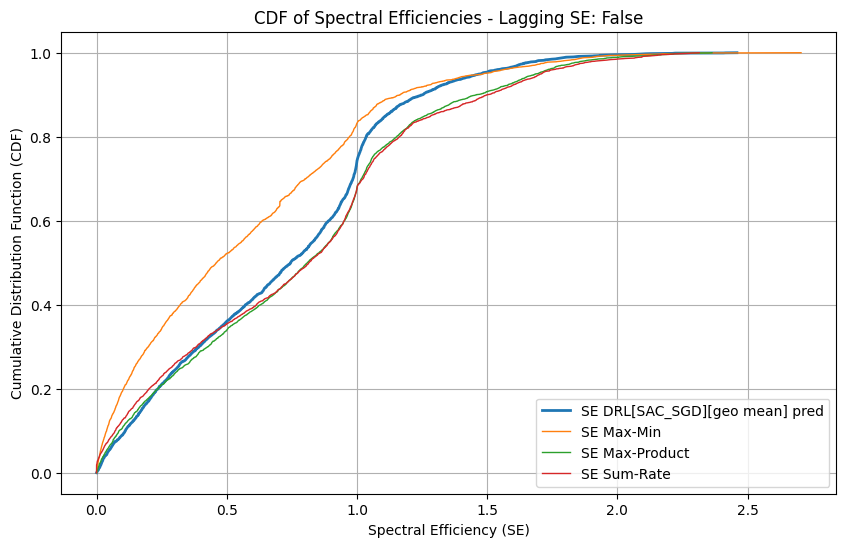

In [11]:
env = MobilityCFmMIMOEnv(APs_positions=APs_positions, UEs_positions=UEs_positions, UEs_mobility=True,
                         reward_method='geo_mean_se')

cf_signal = np.zeros((K, num_of_setups))
cf_interference = np.zeros((K, K, num_of_setups))
cf_pred_power = np.zeros((K, num_of_setups))

cf_SE_model_geo_mean = np.zeros((K, num_of_setups))

SE_maxmin_cell = np.zeros((K, num_of_setups))
SE_maxprod_cell = np.zeros((K, num_of_setups))
SE_sumrate_cell = np.zeros((K, num_of_setups))


obs, info = env.reset()
signal = info['init_signal']
interference = info['init_interference']

prelog_factor = 1

env2 = copy.deepcopy(env)
env3 = copy.deepcopy(env)
env4 = copy.deepcopy(env)

maxmin_signal = copy.deepcopy(signal)
maxprod_signal = copy.deepcopy(signal)
maxsumrate_signal = copy.deepcopy(signal)

maxmin_interference = copy.deepcopy(interference)
maxprod_interference = copy.deepcopy(interference)
maxsumrate_interference = copy.deepcopy(interference)

for n in range(num_of_setups):
    # DRL Agent
    action, _ = model_geo_mean.predict(obs, deterministic=True)
    obs, _, _, _, info = env.step(action)
    cf_SE_model_geo_mean[:, n] = compute_se(info['signal'], info['interference'], info['predicted_power'], prelog_factor)

    updated_ues_positions = info['ues_positions']

    info = env2.maxmin_algo(maxmin_signal, maxmin_interference, max_power, updated_ues_positions, prelog_factor,
                            lagging_SE, None, None)
    maxmin_signal = info['signal']
    maxmin_interference = info['interference']
    maxmin_opt_power = info['optimized_power']
    SE_maxmin_cell[:, n] = compute_se(signal, interference, maxmin_opt_power, prelog_factor)

    info = env3.maxprod_algo(maxprod_signal, maxprod_interference, max_power, updated_ues_positions, prelog_factor,
                             lagging_SE, None, None)
    maxprod_signal = info['signal']
    maxprod_interference = info['interference']
    maxprod_opt_power = info['optimized_power']
    SE_maxprod_cell[:, n] = compute_se(signal, interference, maxprod_opt_power, prelog_factor)

    info = env4.maxsumrate_algo(maxsumrate_signal, maxsumrate_interference, max_power, updated_ues_positions,
                                prelog_factor, lagging_SE, None, None)
    maxsumrate_signal = info['signal']
    maxsumrate_interference = info['interference']
    maxsumrate_opt_power = info['optimized_power']
    SE_sumrate_cell[:, n] = compute_se(signal, interference, maxsumrate_opt_power, prelog_factor)

model_geo_mean_flatten = cf_SE_model_geo_mean.flatten()
sorted_model_geo_mean = np.sort(model_geo_mean_flatten)
model_geo_mean_pred = np.linspace(0, 1, len(sorted_model_geo_mean))

SE_maxmin_flatten = SE_maxmin_cell.flatten()
SE_maxprod_flatten = SE_maxprod_cell.flatten()
SE_sumrate_flatten = SE_sumrate_cell.flatten()

sorted_SE_maxmin = np.sort(SE_maxmin_flatten)
sorted_SE_maxprod = np.sort(SE_maxprod_flatten)
sorted_SE_sumrate = np.sort(SE_sumrate_flatten)

cdf_SE_maxmin = np.linspace(0, 1, len(sorted_SE_maxmin))
cdf_SE_maxprod = np.linspace(0, 1, len(sorted_SE_maxprod))
cdf_SE_sumrate = np.linspace(0, 1, len(sorted_SE_sumrate))

plt.figure(figsize=(10, 6))

plt.plot(sorted_model_geo_mean, model_geo_mean_pred, label='SE DRL[SAC_SGD][geo mean] pred', linewidth=2)

plt.plot(sorted_SE_maxmin, cdf_SE_maxmin, label='SE Max-Min', linewidth=1)
plt.plot(sorted_SE_maxprod, cdf_SE_maxprod, label='SE Max-Product', linewidth=1)
plt.plot(sorted_SE_sumrate, cdf_SE_sumrate, label='SE Sum-Rate', linewidth=1)

plt.xlabel('Spectral Efficiency (SE)')
plt.ylabel('Cumulative Distribution Function (CDF)')
plt.title(f'CDF of Spectral Efficiencies - Lagging SE: {lagging_SE}')
plt.legend()
plt.grid(True)
plt.show()

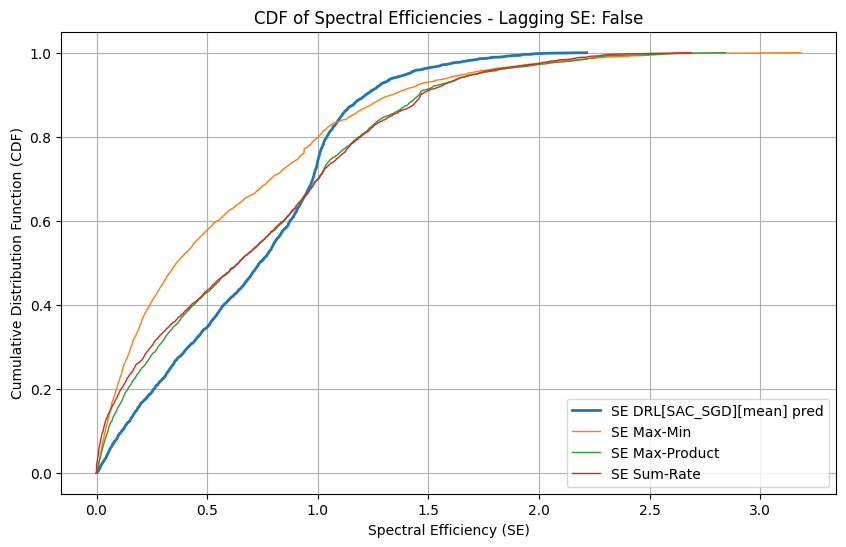

In [12]:
env = MobilityCFmMIMOEnv(APs_positions=APs_positions, UEs_positions=UEs_positions, UEs_mobility=True,
                         reward_method='mean_se')

cf_signal = np.zeros((K, num_of_setups))
cf_interference = np.zeros((K, K, num_of_setups))
cf_pred_power = np.zeros((K, num_of_setups))

cf_SE_model_mean = np.zeros((K, num_of_setups))

SE_maxmin_cell = np.zeros((K, num_of_setups))
SE_maxprod_cell = np.zeros((K, num_of_setups))
SE_sumrate_cell = np.zeros((K, num_of_setups))


obs, info = env.reset()
signal = info['init_signal']
interference = info['init_interference']

prelog_factor = 1

env2 = copy.deepcopy(env)
env3 = copy.deepcopy(env)
env4 = copy.deepcopy(env)

maxmin_signal = copy.deepcopy(signal)
maxprod_signal = copy.deepcopy(signal)
maxsumrate_signal = copy.deepcopy(signal)

maxmin_interference = copy.deepcopy(interference)
maxprod_interference = copy.deepcopy(interference)
maxsumrate_interference = copy.deepcopy(interference)

for n in range(num_of_setups):
    # DRL Agent
    action, _ = model_mean.predict(obs, deterministic=True)
    obs, _, _, _, info = env.step(action)
    cf_SE_model_mean[:, n] = compute_se(info['signal'], info['interference'], info['predicted_power'], prelog_factor)

    updated_ues_positions = info['ues_positions']

    info = env2.maxmin_algo(maxmin_signal, maxmin_interference, max_power, updated_ues_positions, prelog_factor,
                            lagging_SE, None, None)
    maxmin_signal = info['signal']
    maxmin_interference = info['interference']
    maxmin_opt_power = info['optimized_power']
    SE_maxmin_cell[:, n] = compute_se(signal, interference, maxmin_opt_power, prelog_factor)

    info = env3.maxprod_algo(maxprod_signal, maxprod_interference, max_power, updated_ues_positions, prelog_factor,
                             lagging_SE, None, None)
    maxprod_signal = info['signal']
    maxprod_interference = info['interference']
    maxprod_opt_power = info['optimized_power']
    SE_maxprod_cell[:, n] = compute_se(signal, interference, maxprod_opt_power, prelog_factor)

    info = env4.maxsumrate_algo(maxsumrate_signal, maxsumrate_interference, max_power, updated_ues_positions,
                                prelog_factor, lagging_SE, None, None)
    maxsumrate_signal = info['signal']
    maxsumrate_interference = info['interference']
    maxsumrate_opt_power = info['optimized_power']
    SE_sumrate_cell[:, n] = compute_se(signal, interference, maxsumrate_opt_power, prelog_factor)

model_mean_flatten = cf_SE_model_mean.flatten()
sorted_model_mean = np.sort(model_mean_flatten)
model_mean_pred = np.linspace(0, 1, len(sorted_model_mean))

SE_maxmin_flatten = SE_maxmin_cell.flatten()
SE_maxprod_flatten = SE_maxprod_cell.flatten()
SE_sumrate_flatten = SE_sumrate_cell.flatten()

sorted_SE_maxmin = np.sort(SE_maxmin_flatten)
sorted_SE_maxprod = np.sort(SE_maxprod_flatten)
sorted_SE_sumrate = np.sort(SE_sumrate_flatten)

cdf_SE_maxmin = np.linspace(0, 1, len(sorted_SE_maxmin))
cdf_SE_maxprod = np.linspace(0, 1, len(sorted_SE_maxprod))
cdf_SE_sumrate = np.linspace(0, 1, len(sorted_SE_sumrate))

plt.figure(figsize=(10, 6))

plt.plot(sorted_model_mean, model_mean_pred, label='SE DRL[SAC_SGD][mean] pred', linewidth=2)

plt.plot(sorted_SE_maxmin, cdf_SE_maxmin, label='SE Max-Min', linewidth=1)
plt.plot(sorted_SE_maxprod, cdf_SE_maxprod, label='SE Max-Product', linewidth=1)
plt.plot(sorted_SE_sumrate, cdf_SE_sumrate, label='SE Sum-Rate', linewidth=1)

plt.xlabel('Spectral Efficiency (SE)')
plt.ylabel('Cumulative Distribution Function (CDF)')
plt.title(f'CDF of Spectral Efficiencies - Lagging SE: {lagging_SE}')
plt.legend()
plt.grid(True)
plt.show()

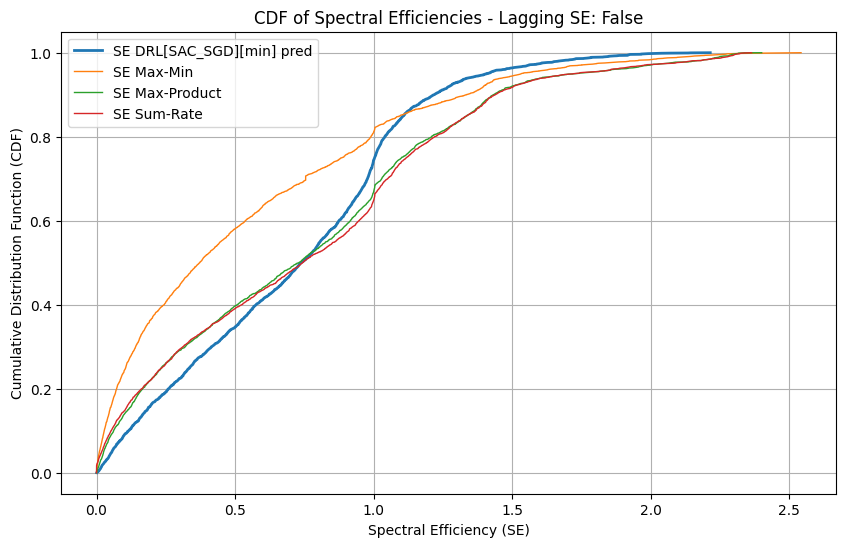

In [13]:
env = MobilityCFmMIMOEnv(APs_positions=APs_positions, UEs_positions=UEs_positions, UEs_mobility=True,
                         reward_method='min_se')

cf_signal = np.zeros((K, num_of_setups))
cf_interference = np.zeros((K, K, num_of_setups))
cf_pred_power = np.zeros((K, num_of_setups))

cf_SE_model_min = np.zeros((K, num_of_setups))

SE_maxmin_cell = np.zeros((K, num_of_setups))
SE_maxprod_cell = np.zeros((K, num_of_setups))
SE_sumrate_cell = np.zeros((K, num_of_setups))


obs, info = env.reset()
signal = info['init_signal']
interference = info['init_interference']

prelog_factor = 1

env2 = copy.deepcopy(env)
env3 = copy.deepcopy(env)
env4 = copy.deepcopy(env)

maxmin_signal = copy.deepcopy(signal)
maxprod_signal = copy.deepcopy(signal)
maxsumrate_signal = copy.deepcopy(signal)

maxmin_interference = copy.deepcopy(interference)
maxprod_interference = copy.deepcopy(interference)
maxsumrate_interference = copy.deepcopy(interference)

for n in range(num_of_setups):
    # DRL Agent
    action, _ = model_min.predict(obs, deterministic=True)
    obs, _, _, _, info = env.step(action)
    cf_SE_model_min[:, n] = compute_se(info['signal'], info['interference'], info['predicted_power'], prelog_factor)

    updated_ues_positions = info['ues_positions']

    info = env2.maxmin_algo(maxmin_signal, maxmin_interference, max_power, updated_ues_positions, prelog_factor,
                            lagging_SE, None, None)
    maxmin_signal = info['signal']
    maxmin_interference = info['interference']
    maxmin_opt_power = info['optimized_power']
    SE_maxmin_cell[:, n] = compute_se(signal, interference, maxmin_opt_power, prelog_factor)

    info = env3.maxprod_algo(maxprod_signal, maxprod_interference, max_power, updated_ues_positions, prelog_factor,
                             lagging_SE, None, None)
    maxprod_signal = info['signal']
    maxprod_interference = info['interference']
    maxprod_opt_power = info['optimized_power']
    SE_maxprod_cell[:, n] = compute_se(signal, interference, maxprod_opt_power, prelog_factor)

    info = env4.maxsumrate_algo(maxsumrate_signal, maxsumrate_interference, max_power, updated_ues_positions,
                                prelog_factor, lagging_SE, None, None)
    maxsumrate_signal = info['signal']
    maxsumrate_interference = info['interference']
    maxsumrate_opt_power = info['optimized_power']
    SE_sumrate_cell[:, n] = compute_se(signal, interference, maxsumrate_opt_power, prelog_factor)

model_min_flatten = cf_SE_model_min.flatten()
sorted_model_min = np.sort(model_min_flatten)
model_min_pred = np.linspace(0, 1, len(sorted_model_min))

SE_maxmin_flatten = SE_maxmin_cell.flatten()
SE_maxprod_flatten = SE_maxprod_cell.flatten()
SE_sumrate_flatten = SE_sumrate_cell.flatten()

sorted_SE_maxmin = np.sort(SE_maxmin_flatten)
sorted_SE_maxprod = np.sort(SE_maxprod_flatten)
sorted_SE_sumrate = np.sort(SE_sumrate_flatten)

cdf_SE_maxmin = np.linspace(0, 1, len(sorted_SE_maxmin))
cdf_SE_maxprod = np.linspace(0, 1, len(sorted_SE_maxprod))
cdf_SE_sumrate = np.linspace(0, 1, len(sorted_SE_sumrate))

plt.figure(figsize=(10, 6))

plt.plot(sorted_model_mean, model_mean_pred, label='SE DRL[SAC_SGD][min] pred', linewidth=2)

plt.plot(sorted_SE_maxmin, cdf_SE_maxmin, label='SE Max-Min', linewidth=1)
plt.plot(sorted_SE_maxprod, cdf_SE_maxprod, label='SE Max-Product', linewidth=1)
plt.plot(sorted_SE_sumrate, cdf_SE_sumrate, label='SE Sum-Rate', linewidth=1)

plt.xlabel('Spectral Efficiency (SE)')
plt.ylabel('Cumulative Distribution Function (CDF)')
plt.title(f'CDF of Spectral Efficiencies - Lagging SE: {lagging_SE}')
plt.legend()
plt.grid(True)
plt.show()

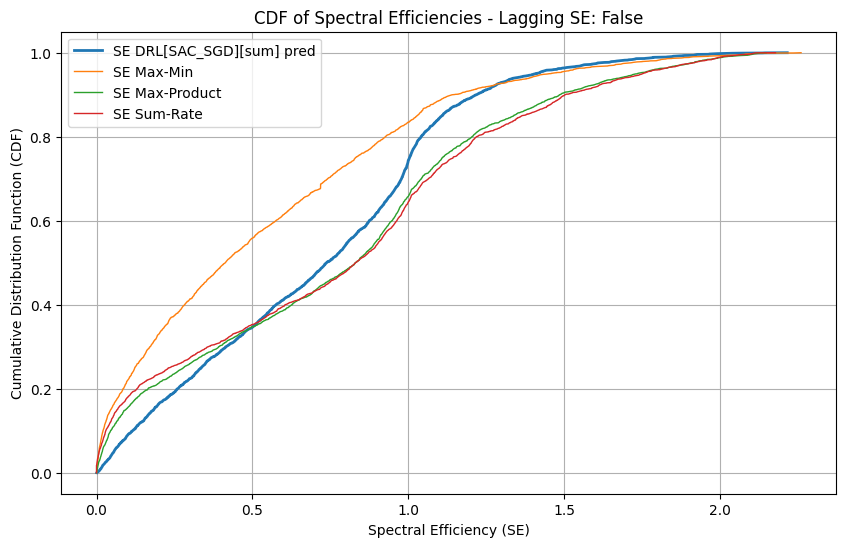

In [14]:
env = MobilityCFmMIMOEnv(APs_positions=APs_positions, UEs_positions=UEs_positions, UEs_mobility=True,
                         reward_method='sum_se')

cf_signal = np.zeros((K, num_of_setups))
cf_interference = np.zeros((K, K, num_of_setups))
cf_pred_power = np.zeros((K, num_of_setups))

cf_SE_model_sum = np.zeros((K, num_of_setups))

SE_maxmin_cell = np.zeros((K, num_of_setups))
SE_maxprod_cell = np.zeros((K, num_of_setups))
SE_sumrate_cell = np.zeros((K, num_of_setups))


obs, info = env.reset()
signal = info['init_signal']
interference = info['init_interference']

prelog_factor = 1

env2 = copy.deepcopy(env)
env3 = copy.deepcopy(env)
env4 = copy.deepcopy(env)

maxmin_signal = copy.deepcopy(signal)
maxprod_signal = copy.deepcopy(signal)
maxsumrate_signal = copy.deepcopy(signal)

maxmin_interference = copy.deepcopy(interference)
maxprod_interference = copy.deepcopy(interference)
maxsumrate_interference = copy.deepcopy(interference)

for n in range(num_of_setups):
    # DRL Agent
    action, _ = model_min.predict(obs, deterministic=True)
    obs, _, _, _, info = env.step(action)
    cf_SE_model_sum[:, n] = compute_se(info['signal'], info['interference'], info['predicted_power'], prelog_factor)

    updated_ues_positions = info['ues_positions']

    info = env2.maxmin_algo(maxmin_signal, maxmin_interference, max_power, updated_ues_positions, prelog_factor,
                            lagging_SE, None, None)
    maxmin_signal = info['signal']
    maxmin_interference = info['interference']
    maxmin_opt_power = info['optimized_power']
    SE_maxmin_cell[:, n] = compute_se(signal, interference, maxmin_opt_power, prelog_factor)

    info = env3.maxprod_algo(maxprod_signal, maxprod_interference, max_power, updated_ues_positions, prelog_factor,
                             lagging_SE, None, None)
    maxprod_signal = info['signal']
    maxprod_interference = info['interference']
    maxprod_opt_power = info['optimized_power']
    SE_maxprod_cell[:, n] = compute_se(signal, interference, maxprod_opt_power, prelog_factor)

    info = env4.maxsumrate_algo(maxsumrate_signal, maxsumrate_interference, max_power, updated_ues_positions,
                                prelog_factor, lagging_SE, None, None)
    maxsumrate_signal = info['signal']
    maxsumrate_interference = info['interference']
    maxsumrate_opt_power = info['optimized_power']
    SE_sumrate_cell[:, n] = compute_se(signal, interference, maxsumrate_opt_power, prelog_factor)

model_sum_flatten = cf_SE_model_sum.flatten()
sorted_model_min = np.sort(model_sum_flatten)
model_min_pred = np.linspace(0, 1, len(sorted_model_min))

SE_maxmin_flatten = SE_maxmin_cell.flatten()
SE_maxprod_flatten = SE_maxprod_cell.flatten()
SE_sumrate_flatten = SE_sumrate_cell.flatten()

sorted_SE_maxmin = np.sort(SE_maxmin_flatten)
sorted_SE_maxprod = np.sort(SE_maxprod_flatten)
sorted_SE_sumrate = np.sort(SE_sumrate_flatten)

cdf_SE_maxmin = np.linspace(0, 1, len(sorted_SE_maxmin))
cdf_SE_maxprod = np.linspace(0, 1, len(sorted_SE_maxprod))
cdf_SE_sumrate = np.linspace(0, 1, len(sorted_SE_sumrate))

plt.figure(figsize=(10, 6))

plt.plot(sorted_model_mean, model_mean_pred, label='SE DRL[SAC_SGD][sum] pred', linewidth=2)

plt.plot(sorted_SE_maxmin, cdf_SE_maxmin, label='SE Max-Min', linewidth=1)
plt.plot(sorted_SE_maxprod, cdf_SE_maxprod, label='SE Max-Product', linewidth=1)
plt.plot(sorted_SE_sumrate, cdf_SE_sumrate, label='SE Sum-Rate', linewidth=1)

plt.xlabel('Spectral Efficiency (SE)')
plt.ylabel('Cumulative Distribution Function (CDF)')
plt.title(f'CDF of Spectral Efficiencies - Lagging SE: {lagging_SE}')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
from _utils import plot_se_cdf_pdf